In [148]:
import numpy as np
def r(x):
    Ht = 0.01
    L  = 1
    return 2*Ht + Ht*np.cos(2*np.pi*x/L)

In [149]:
import numpy as np

class Grid:
    """Class defining a one-dimensional grid"""

    def __init__(self, lx, r, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            r ......radial distance from the centreline of the converging-diverging duct
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv

        # Calculate the control volume length
        dx = lx/float(ncv)

        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])

        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] +
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])

        # Calculate face areas
        self._Af = np.pi*r(self._xf)**2
#-----------------------------------------------------------------------------------------------------------------------
        # Calculate the outer surface area for each cell
        #x1 = np.linspace(0,lx,ncv)
        #self._Ao = 2*np.pi*r(x1)*dx 
        self._Ao = 1/2*(2*np.pi*r(self._xf[0:-1]) + 2*np.pi*r(self._xf[1:]))*dx
     
        # Calculate cell volumes
        #self._vol = np.pi*r(x1)**2*dx
        self._vol = 1/3*np.pi*dx*(r(self._xf[1:])**2 + r(self._xf[0:-1])**2 + r(self._xf[0:-1])*r(self._xf[1:]))
#-----------------------------------------------------------------------------------------------------------------------
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def xf(self):
        """Face location array"""
        return self._xf

    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP

    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]

    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]

    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]

    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]

    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao

    @property
    def vol(self):
        """Cell volume array"""
        return self._vol


In [150]:
import numpy

class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, phi, phiold, rho, const, dt):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._phiold = phiold
        self._rho = rho
        self._const = const
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        transient = self._rho*self._const*self._grid.vol*(self._phi[1:-1]-self._phiold[1:-1])/self._dt

        # Calculate the linearization coefficient
        coeff = self._rho*self._const*self._grid.vol/self._dt

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeff)
        coeffs.accumulate_rP(transient)

        return coeffs

In [151]:
class UpwindAdvectionModel:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, const, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._const = const
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._const*mdote[:-1]*self._phie[:-1]
        flux_e = self._const*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._const*mdote[1:]*self._phi[1:-1] + self._const*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._const*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._const*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [152]:
import numpy as np

class CentralAdvectionModel:
    """Class defining an Central advection model"""

    def __init__(self, grid, phi, Uhe, rho, const, west_bc, east_bc,alphaeatLB,alphaeatRB):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._const = const
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)
#----------------------------------------------------------------------------------------------------------------------------
        self._alphaeatLB = alphaeatLB # This is newly added to specify the value of alphae at the left boundary
        self._alphaeatRB = alphaeatRB # This is newly added to specify the value of alphae at the right boundary
#----------------------------------------------------------------------------------------------------------------------------

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
#---------------------------------------------------------------------------------------------------------------------------- 
        # Calculate the weighting factors
        self._alphae[0] = self._alphaeatLB # This is newly added to specify the value of alphae at the left boundary
        for i in range(1,self._grid.ncv):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        self._alphae[self._grid.ncv] = self._alphaeatRB # This is newly added to specify the value of alphae at the right boundary
#----------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------- 
# The following segment is coded to calculate the east integration point values and values at boundaries according to the 
# background theory of CDS scheme

        # Calculate the east integration point values and values at boundaries      
        # For cells
        for i in range(1,self._grid.ncv):
            self._phie[i] = (1/2)*self._phi[i] + (1/2)*self._phi[i+1]
            
        # For boundaries
        # At the left boundary 
        self._phie[0] = ((1 + self._alphae[0])/2)*self._phi[0] + ((1 - self._alphae[0])/2)*self._phi[1]
        # At the right boundary
        self._phie[-1] = ((1 + self._alphae[self._grid.ncv])/2)*self._phi[-2] + ((1 - self._alphae[self._grid.ncv])/2)*self._phi[-1]

#---------------------------------------------------------------------------------------------------------------------------- 

        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._const*mdote[:-1]*self._phie[:-1]
        flux_e = self._const*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._const*mdote[1:]*self._phi[1:-1] + self._const*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._const*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._const*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [153]:
import numpy as np

class QUICKAdvectionModel:
    """Class defining an Central advection model"""

    def __init__(self, grid, phi, Uhe, rho, const, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._const = const
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)


    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
#---------------------------------------------------------------------------------------------------------------------------- 
        # Calculate the weighting factors

        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1  
#---------------------------------------------------------------------------------------------------------------------------- 
# The following segment is coded to calculate the east integration point values and values at boundaries according to the 
# background theory of QUICK scheme


        # Calculate the east integration point values and values at boundaries
        # For cells
        for i in range (1,self._grid.ncv): 
            if self._Uhe[i] < 0:
            # for flow in negative direction
                s = ((grid.xf[i] - grid.xP[i+1])*(grid.xf[i] - grid.xP[i]))/((grid.xP[i+2] - grid.xP[i+1])*(grid.xP[i+2] - grid.xP[i]))
                t = ((grid.xf[i] - grid.xP[i+2])*(grid.xf[i] - grid.xP[i]))/((grid.xP[i+1] - grid.xP[i+2])*(grid.xP[i+1] - grid.xP[i]))
                u = ((grid.xf[i] - grid.xP[i+1])*(grid.xf[i] - grid.xP[i+2]))/((grid.xP[i] - grid.xP[i+1])*(grid.xP[i] - grid.xP[i+2]))
                self._phie[i] = s*self._phi[i+2] + t*self._phi[i+1] + u*self._phi[i]
             
            else:
                # for flow in positive direction
                p = ((grid.xf[i] - grid.xP[i])*(grid.xf[i] - grid.xP[i+1]))/((grid.xP[i-1] - grid.xP[i])*(grid.xP[i-1] - grid.xP[i+1]))
                q = ((grid.xf[i] - grid.xP[i-1])*(grid.xf[i] - grid.xP[i+1]))/((grid.xP[i] - grid.xP[i-1])*(grid.xP[i] - grid.xP[i+1]))
                r = ((grid.xf[i] - grid.xP[i-1])*(grid.xf[i] - grid.xP[i]))/((grid.xP[i+1] - grid.xP[i-1])*(grid.xP[i+1] - grid.xP[i]))
                self._phie[i] = p*self._phi[i-1] + q*self._phi[i] + r*self._phi[i+1]
                    
        
        # For boundaries
        # At the left boundary 
        self._phie[0] = ((1 + self._alphae[0])/2)*self._phi[0] + ((1 - self._alphae[0])/2)*self._phi[1]
        # At the right boundary
        self._phie[-1] = ((1 + self._alphae[self._grid.ncv])/2)*self._phi[-2] + ((1 - self._alphae[self._grid.ncv])/2)*self._phi[-1]
#---------------------------------------------------------------------------------------------------------------------------- 
      
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._const*mdote[:-1]*self._phie[:-1]
        flux_e = self._const*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._const*mdote[1:]*self._phi[1:-1] + self._const*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._const*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._const*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [154]:
class AdvectingVelocityModel:
    """Class defining an advecting velocity model"""

    def __init__(self, grid, dhat, Uhe, P, U, coeffs):
        """Constructor"""
        self._grid = grid
        self._dhat = dhat
        self._Uhe = Uhe
        self._P = P
        self._U = U
        self._coeffs = coeffs

    def update(self):
        """Function to update the advecting velocity array"""

        # Calculate the pressure gradients across the faces
        gradPw = (self._P[1:-1]-self._P[0:-2])/self._grid.dx_WP
        gradPe = (self._P[2:]-self._P[1:-1])/self._grid.dx_PE
        
        # Calculate the cell pressure gradients
        gradP = 0.5*(gradPw + gradPe)
          
        # Calculate damping coefficient, dhat
        Ve = 0.5*(self._grid.vol[0:-1] + self._grid.vol[1:])
        ae = 0.5*(self._coeffs.aP[0:-1] + self._coeffs.aP[1:])
        self._dhat[1:-1] = Ve/ae

        # Update the advecting velocity
        self._Uhe[0] = self._U[0]
        self._Uhe[1:-1] = 0.5*(self._U[1:-2] + self._U[2:-1]) - self._dhat[1:-1]*(gradPe[:-1] - 0.5*(gradP[:-1] + gradP[1:]))
        self._Uhe[-1] = self._U[-1]

In [155]:

class PressureForceModel:
    """Class defining a pressure force model"""

    def __init__(self, grid, P, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._P = P
        self._west_bc = west_bc
        self._east_bc = east_bc

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the pressure force
        gradPw = (self._P[1:-1]-self._P[0:-2])/self._grid.dx_WP
        gradPe = (self._P[2:]-self._P[1:-1])/self._grid.dx_PE
        force = 0.5*(gradPw + gradPe)*self._grid.vol
          
        # Calculate the linearization coefficients
        coeffW = - 0.5*self._grid.vol/self._grid.dx_WP
        coeffE = 0.5*self._grid.vol/self._grid.dx_PE
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(force)

        # Return the modified coefficient array
        return coeffs

In [156]:
class MassConservationEquation:
    """Class defining a mass conservation equation"""

    def __init__(self, grid, U, P, dhat, Uhe, rho, 
                 P_west_bc, P_east_bc, U_west_bc, U_east_bc):
        """Constructor"""
        self._grid = grid
        self._U = U
        self._P = P
        self._dhat = dhat
        self._Uhe = Uhe
        self._rho = rho
        self._P_west_bc = P_west_bc
        self._P_east_bc = P_east_bc
        self._U_west_bc = U_west_bc
        self._U_east_bc = U_east_bc

    def add(self, PP_coeffs, PU_coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the mass imbalance, based on advecting velocities
        imbalance = self._rho*self._grid.Ae*self._Uhe[1:] - self._rho*self._grid.Aw*self._Uhe[:-1]
              
        # Calculate the linearization coefficients on pressure
        PP_coeffW = np.concatenate((np.array([0]), -self._rho*self._grid.Aw[1:]*self._dhat[1:-1]/self._grid.dx_WP[1:]))
        PP_coeffE = np.concatenate((-self._rho*self._grid.Ae[:-1]*self._dhat[1:-1]/self._grid.dx_PE[:-1], np.array([0])))
        PP_coeffP = - PP_coeffW - PP_coeffE
        
        # Calculate the linearization coefficients on velocity
        PU_coeffW = np.concatenate((np.array([-self._rho*self._grid.Aw[0]]), -0.5*self._rho*self._grid.Aw[1:]))
        PU_coeffE = np.concatenate((0.5*self._rho*self._grid.Ae[:-1], np.array([self._rho*self._grid.Ae[-1]])))
        PU_coeffP = np.concatenate((np.array([0]), PU_coeffW[1:])) + np.concatenate((PU_coeffE[:-1], np.array([0])))

        # Modify the linearization coefficients on the boundaries 
        # (velocity only, since pressure is already zero)
        PU_coeffP[0] += PU_coeffW[0]*self._U_west_bc.coeff()
        PU_coeffP[-1] += PU_coeffE[-1]*self._U_east_bc.coeff()

        # Zero the boundary coefficients that are not used
        PU_coeffW[0] = 0.0
        PU_coeffE[-1] = 0.0

        # Add to coefficient arrays
        PP_coeffs.accumulate_aP(PP_coeffP)
        PP_coeffs.accumulate_aW(PP_coeffW)
        PP_coeffs.accumulate_aE(PP_coeffE)
        PP_coeffs.accumulate_rP(imbalance)
        PU_coeffs.accumulate_aP(PU_coeffP)
        PU_coeffs.accumulate_aW(PU_coeffW)
        PU_coeffs.accumulate_aE(PU_coeffE)

        # Return the modified coefficient arrays
        return PP_coeffs, PU_coeffs

In [157]:
#------------------------------------is the model correct?-------------------------------------------------------------------#
class ExtrapolatedBc:
    """Class defining an extrapolated boundary condition"""

    def __init__(self, phi, grid, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - (((self._phi[2]-self._phi[1])/self._grid.dx_PE[0])*self._grid.dx_WP[0])
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + (((self._phi[-2]-self._phi[-3])/self._grid.dx_WP[-1])*self._grid.dx_PE[-1])
        else:
            raise ValueError("Unknown boundary location")

    def coeff(self):
        """Return the linearization coefficient"""
        if self._loc is BoundaryLocation.WEST:
            return 1 + (1/self._grid.dx_PE[0])*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return 1 + (1/self._grid.dx_WP[-1])*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            pass # Is the following correct????????????????????????????????????????????
            self._phi[0] = self._phi[1] - ((self._phi[2]-self._phi[1])/self._grid.dx_PE[0])*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            pass # Is the following correct????????????????????????????????????????????
            self._phi[-1] = self._phi[-2] + (((self._phi[-2]-self._phi[-3])/self._grid.dx_WP[-1])*self._grid.dx_PE[-1])
        else:
            raise ValueError("Unknown boundary location")


In [158]:
from Lesson5.ScalarCoeffs import ScalarCoeffs
from Lesson5.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson5.Models import DiffusionModel
from Lesson5.LinearSolver import solve

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 1.0
ncv = 64
grid = Grid(lx, r, ncv)

# Set the timestep information
nTime = 1
dt = 1e9
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1000
mu = 1e-3

# Define the coefficients
PU_coeffs = ScalarCoeffs(grid.ncv)
PP_coeffs = ScalarCoeffs(grid.ncv)
UP_coeffs = ScalarCoeffs(grid.ncv)
UU_coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
U0 = 2
P0 = 0

# Initialize field variable arrays
U = U0*np.ones(grid.ncv+2)
P = P0*np.ones(grid.ncv+2)

# Initialize advecting velocity and damping coefficient array
dhat = np.zeros(grid.ncv+1)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions for velocity
U_west_bc = DirichletBc(U, grid, U0, BoundaryLocation.WEST)
U_east_bc = NeumannBc(U, grid, 0, BoundaryLocation.EAST)

# Define boundary conditions for pressure
P_west_bc = ExtrapolatedBc(P, grid, BoundaryLocation.WEST)
P_east_bc = DirichletBc(P, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
U_west_bc.apply()
U_east_bc.apply()
P_west_bc.apply()
P_east_bc.apply()

# Define the transient model
Uold = np.copy(U)
transient = FirstOrderTransientModel(grid, U, Uold, rho, 1, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, U, mu, U_west_bc, U_east_bc)

# Define the advection model self, 
#advection = UpwindAdvectionModel(grid, U, Uhe, rho, 1, U_west_bc, U_east_bc)
# advection = CentralAdvectionModel(grid, U, Uhe, rho, 1, U_west_bc, U_east_bc,1,1)
advection = QUICKAdvectionModel(grid, U, Uhe, rho, 1, U_west_bc, U_east_bc)



# Define the pressure force model
pressure = PressureForceModel(grid, P, P_west_bc, P_east_bc)

# Define advecting velocity model
advecting = AdvectingVelocityModel(grid, dhat, Uhe, P, U, UU_coeffs)

# Define conservation of mass equation
mass = MassConservationEquation(grid, U, P, dhat, Uhe, rho, 
                                P_west_bc, P_east_bc, U_west_bc, U_east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" velocity field
    Uold[:] = U[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        
        # Zero all of the equations
        PP_coeffs.zero()
        PU_coeffs.zero()
        UU_coeffs.zero()
        UP_coeffs.zero()     
        
        # Assemble the momentum equations
        #   Note: do this before mass, because the coeffs are needed to compute advecting velocity
        UU_coeffs = diffusion.add(UU_coeffs)
        UU_coeffs = advection.add(UU_coeffs)
        UU_coeffs = transient.add(UU_coeffs)
        UP_coeffs = pressure.add(UP_coeffs)
      
        # Assemble the mass equations
        advecting.update()
        PP_coeffs, PU_coeffs = mass.add(PP_coeffs, PU_coeffs)

        # Compute residuals and check for convergence
        PmaxResid = norm(PU_coeffs.rP + PP_coeffs.rP, np.inf)
        PavgResid = np.mean(np.absolute(PU_coeffs.rP + PP_coeffs.rP))
        UmaxResid = norm(UU_coeffs.rP + UP_coeffs.rP, np.inf)
        UavgResid = np.mean(np.absolute(UU_coeffs.rP + UP_coeffs.rP))
        print("Iteration = {}.".format(i))
        print("  Mass:     Max. Resid. = {}; Avg. Resid. = {}".format(PmaxResid, PavgResid))
        print("  Momentum: Max. Resid. = {}; Avg. Resid. = {}".format(UmaxResid, UavgResid))
        if PmaxResid < converged and UmaxResid < converged:
            break
    
        # Solve the sparse matrix system
        dP, dU = solve(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs)
    
        # Update the solutions 
        P[1:-1] += dP
        U[1:-1] += dU
        
        # Update boundary conditions
        U_west_bc.apply()
        U_east_bc.apply()
        P_west_bc.apply()
        P_east_bc.apply()
        
        # Update the advecting velocities
        advecting.update()



Timestep = 0; Time = 1000000000.0
Iteration = 0.
  Mass:     Max. Resid. = 0.27129313586647763; Avg. Resid. = 0.15707963267948966
  Momentum: Max. Resid. = 0.0; Avg. Resid. = 0.0
Iteration = 1.
  Mass:     Max. Resid. = 0.5910926283646631; Avg. Resid. = 0.058962386934712396
  Momentum: Max. Resid. = 6.23633424235603; Avg. Resid. = 2.1051545907726683
Iteration = 2.
  Mass:     Max. Resid. = 1.71141448753791; Avg. Resid. = 0.08679520359135338
  Momentum: Max. Resid. = 8.434057444640947; Avg. Resid. = 0.2344571316796994
Iteration = 3.
  Mass:     Max. Resid. = 2.916883458584397; Avg. Resid. = 0.10675959972593456
  Momentum: Max. Resid. = 21.051995708433687; Avg. Resid. = 0.5572821885257788
Iteration = 4.
  Mass:     Max. Resid. = 6.108113580267791; Avg. Resid. = 0.19729042268283675
  Momentum: Max. Resid. = 23.463935299488238; Avg. Resid. = 0.7622475224209909
Iteration = 5.
  Mass:     Max. Resid. = 0.5939158980345978; Avg. Resid. = 0.04280120108363401
  Momentum: Max. Resid. = 4.92788996

1.5639829339801259


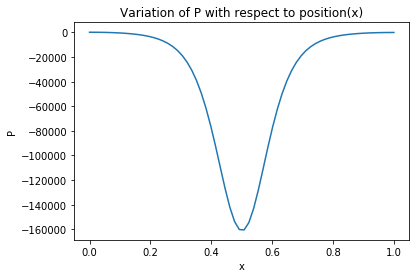

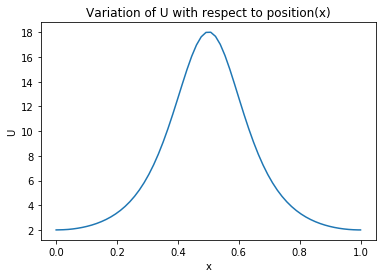

In [159]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# Define the grid
lx = 1.0
ncv = 64
grid = Grid(lx, r, ncv)
CD = 2*(P[0]-P[-1])/rho*U[0]**2
#x = np.linspace(0,1,ncv+2)
#print(x,U)
print(CD)
plt.plot(grid.xP, P)
plt.title('Variation of P with respect to position(x)')
plt.xlabel("x")
plt.ylabel("P")
plt.show()
plt.plot(grid.xP, U)
plt.title('Variation of U with respect to position(x)')
plt.xlabel("x")
plt.ylabel("U")
plt.show()